# Preparation

In [1]:
#!git clone https://github.com/facebookresearch/detr

In [2]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
#import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion, DETR
#################################################################

import matplotlib.pyplot as plt

#Glob
from glob import glob

#added
import json
import itertools
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from numpy.random import rand, randint, ranf, randn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torchvision.transforms.functional as tf
from util.misc import (NestedTensor, nested_tensor_from_tensor_list,
                       accuracy, get_world_size, interpolate,
                       is_dist_avail_and_initialized)
from icecream import ic
%matplotlib inline

# Utils

* AverageMeter - class for averaging loss,metric,etc over epochs

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Configuration

Basic configuration for this model

# Preparing the Data
## KITTI
Coordinate system in KITTI is shown in below.

- http://www.cvlibs.net/datasets/kitti/setup.php
- https://github.com/NVIDIA/DIGITS/blob/v4.0.0-rc.3/digits/extensions/data/objectDetection/README.md

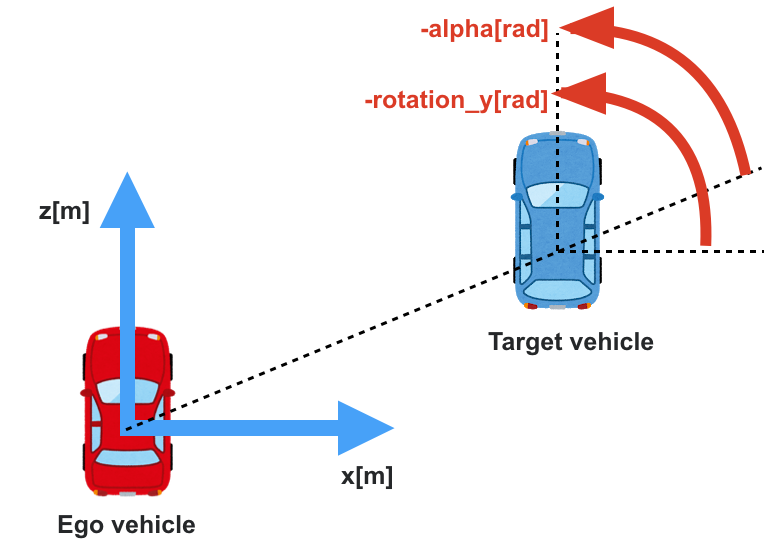

In [4]:
from  IPython.display import Image as ipImage
ipImage("../doc/KITTI_coordinate.png")

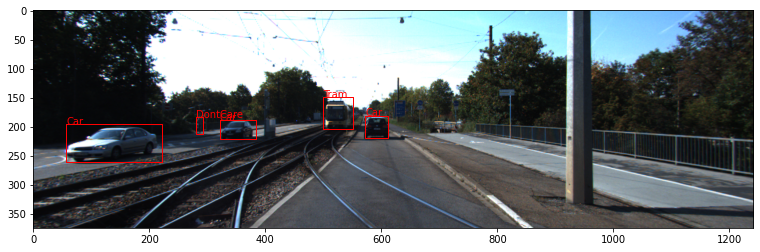

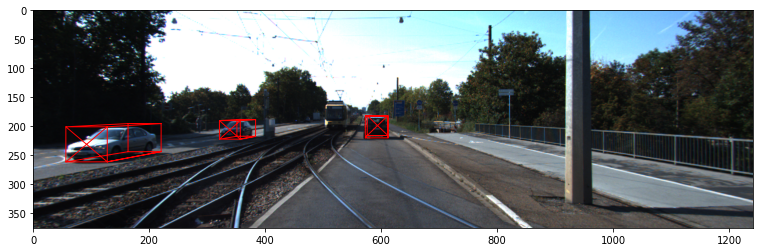

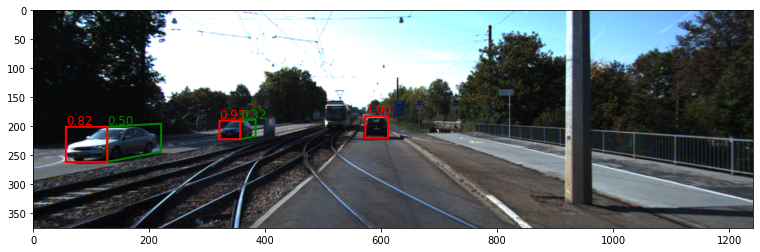

In [5]:
class KITTIData():
    def __init__(self, KITTIPath=None):
        if not KITTIPath==None:
            self.dataset_path = KITTIPath
        else:
            self.dataset_path = "../../../Dataset/KITTI/training/"
        self.img_folder_path = self.dataset_path + "image_2/"
        self.label_folder_path = self.dataset_path + "label_2/"
        self.calib_folder_path = self.dataset_path + "calib/"
        
        self.img_names = glob(self.img_folder_path + "*.png")
        for i in range(len(self.img_names)):
            self.img_names[i] = self.img_names[i].split('/')[-1][:-4]
        
        #print("Preparing", len(self.img_names), "images from KITTI.")
        #
        #self.annotations_list = pd.DataFrame()
        #names = ["type", "truncated", "occluded", "alpha", "left", "top", "right", "bottom",
        #         "height", "width", "length", "x", "y", "z", "rotation_y", ]
        #
        #for img_name in tqdm(self.img_names):
        #    label_path = self.label_folder_path + img_name + ".txt"
        #    annotations = pd.read_csv(label_path, names = names, sep='\s+')
        #    annotations["img_name"] = img_name
        #    self.annotations_list = self.annotations_list.append(annotations)
        #self.annotations_list = self.annotations_list[["img_name"]+names]
        #
        #print("Loading completed!")
        self.annotation_items = ["type", "truncated", "occluded", "alpha", "left", "top", "right", "bottom",
                                 "height", "width", "length", "x", "y", "z", "rotation_y", ]
        
    def __len__(self):
        return len(self.img_names)
        
    def line2P(self, l):
        P_elem = l.split()[1:]
        P = np.array(P_elem, dtype=np.float).reshape(3,-1)
        return P
    
    def readCalib(self, calib_name):
        calib_name = self.calib_folder_path + calib_name + ".txt"
        with open(calib_name) as f:
            P0 = self.line2P(f.readline())
            P1 = self.line2P(f.readline())
            P2 = self.line2P(f.readline())
            P3 = self.line2P(f.readline())
            R0_rect = self.line2P(f.readline())
            Tr_velo_to_cam = self.line2P(f.readline())
            Tr_imu_to_velo = self.line2P(f.readline())
        return P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo
    
    def getPILImg(self, img_name):
        img_path = self.img_folder_path + img_name + ".png"
        img = Image.open(img_path)
        return img
    
    def getAnnotation(self, img_name):
        #return self.annotations_list[self.annotations_list["img_name"]==img_name]
        label_path = self.label_folder_path + img_name + ".txt"
        annotation = pd.read_csv(label_path, names=self.annotation_items, sep='\s+')
        annotation["img_name"] = img_name
        return annotation
    
    def plot2Dbb(self, img_name):
        annotations = self.getAnnotation(img_name)
        img = self.getPILImg(img_name)
        
        plt.figure(figsize=(15, 4))
        plt.imshow(img)
        
        for _, anno in annotations.iterrows():
            _type,left,top,right,bottom = anno["type"],anno["left"],anno["top"],anno["right"],anno["bottom"]
            plt.plot([left,right,right,left,left],
                     [top,top,bottom,bottom,top],
                     color="r",linewidth=1
                )
            plt.text(left, top, _type, color="r")

    def calcSurcfaceAngle(self, pts3D):
        """
        return belows. Element of each list is [front, right, back, left]
        - list of cos(angle) for each surface
        """
        # 直方体の8点から、隠れた点を除いて出力する
        face_mask = np.array([[1,1,0,0,1,1,0,0], # front
                              [0,1,1,0,0,1,1,0], # right
                              [0,0,1,1,0,0,1,1], # back
                              [1,0,0,1,1,0,0,1]  # left
                             ])
        # 直方体の8点から、隠れた点を除いて出力する
        # face_idx = np.array([[0,1,5,4], # front face
        #                      [1,2,6,5], # right face
        #                      [2,3,7,6], # back face
        #                      [3,0,4,7]]) # left face
                             
        # 直方体の中心位置を計算
        c_rectangular = np.sum(pts3D, axis=1)/8
    
        # 各面の法線と面からカメラへの直線がなす角度が90度以下であればその面は見える
        cosForSfcs = []
        for i in range(4):
            p_in_plane = pts3D * face_mask[i] # 平面の4つの頂点
            c_plane = np.sum(p_in_plane, axis=1)/4 # 平面の中心
            normal = c_plane - c_rectangular# 平面の法線ベクトル
            c_to_O = -c_plane # 平面の中心からカメラ位置へのベクトル
            
            # cosを計算して保存
            cos = np.dot(c_to_O, normal)/np.linalg.norm(c_to_O)/np.linalg.norm(normal)
            cosForSfcs.append(cos)
            # 面の頂点を保存
            #ptsForSfcs.append(pts3D[:,face_idx[i]])
        return cosForSfcs
    
    def projectToImage(self, pts3D, P):
        P = np.array(P)
        
        ones = np.ones([1,pts3D.shape[1]])
        pts3D = np.append(pts3D, ones, axis=0)
        pts2D = np.dot(P, pts3D)
        pts2D[0] /= pts2D[2]
        pts2D[1] /= pts2D[2]
        pts2D = np.delete(pts2D, obj=2, axis=0)
        return pts2D
    
    def calc3Dcoord(self, obj, P):
        # 直方体の各頂点のxyz座標を計算
        face_idx = np.array([[0,1,5,4], # front face
                             [1,2,6,5], # right face
                             [2,3,7,6], # back face
                             [3,0,4,7]]) # left face
        ry = obj["rotation_y"]
        R = np.array([[ np.cos(ry), 0, np.sin(ry)],
                      [          0, 1,          0],
                      [-np.sin(ry), 0, np.cos(ry)]],
                     dtype=np.float)
        l = obj["length"]
        w = obj["width"]
        h = obj["height"]
        corners = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2],
                            [0,0,0,0,-h,-h,-h,-h],
                            [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]],
                           dtype=np.float).reshape(3,-1)
        pts3D = np.dot(R,corners)
        xyz = np.array([obj["x"], obj["y"], obj["z"]], dtype=np.float).reshape([3,1])
        pts3D += xyz
        return pts3D
    
    def devideToEachSurface(self, pts):
        # 直方体の各頂点のxyz座標を計算
        face_idx = np.array([[0,1,5,4], # front face
                             [1,2,6,5], # right face
                             [2,3,7,6], # back face
                             [3,0,4,7]]) # left face
        
        ptsForSfcs = []
        for i in range(4):
            ptsForSfcs.append(pts[:,face_idx[i]])

        return ptsForSfcs
    
    def calcPseudo3Dbb(self, obj, P):
        """
        return belows. if any surface is unvisible, each array stores np.nans
        - 4 corners of front or back surface as np.array shaped 2x4
        - 4 corners of left or right surface as np.array shaped 2x4
        - cos angle of front or back surface
        - cos angle of left or right surface
        """
        pts3D = self.calc3Dcoord(obj, P)
        pts2D = self.projectToImage(pts3D, P)
        pts2D_devided = self.devideToEachSurface(pts2D)
        cosForSfcs = self.calcSurcfaceAngle(pts3D)

        # 返り値の変数を用意、デフォルト値を設定
        pts2D_fr = np.zeros([2,4])
        pts2D_fr[:,:] = np.nan
        pts2D_lr = pts2D_fr.copy()
        cos_fr, cos_lr = np.nan, np.nan
        
        # 見えている面を選ぶ
        for i in range(0,3,2):
            if cosForSfcs[i]>0:
                pts2D_fr = pts2D_devided[i]
                cos_fr = cosForSfcs[i]
                break
        for i in range(1,4,2):
            if cosForSfcs[i]>0:
                pts2D_lr = pts2D_devided[i]
                cos_lr = cosForSfcs[i]
                break
        # pts2D_fr, lrをx座標でソートする。下の順番になる
        # left-bottom, left-top, right-bottom, right-top
        pts2D_fr = pts2D_fr[:,pts2D_fr[0].argsort()].T
        pts2D_lr = pts2D_lr[:,pts2D_lr[0].argsort()].T
        
        return pts2D_fr, pts2D_lr, cos_fr, cos_lr
    
    def array2Pseudo3Dbb(self, pts2D_fr, pts2D_lr, cos_fr, cos_lr):
        coord = np.append(pts2D_fr, pts2D_lr).reshape([8,2])
        pose = np.append(cos_fr, cos_lr)
        obj = {"coord":coord,
               "pose":pose}
        return obj
    
    @staticmethod
    def arrays2bb(ts2D_fr, pts2D_lr=np.array([0,2])):
        # convert from array to 2Dbb
        array2D = np.append(ts2D_fr, pts2D_lr)
        array2D = array2D[np.logical_not(np.isnan(array2D))].reshape([-1, 2])
        x0 = np.min(array2D[:,0])
        x1 = np.max(array2D[:,0])
        y0 = np.min(array2D[:,1])
        y1 = np.max(array2D[:,1])

        c_x, c_y = (x0+x1)/2, (y0+y1)/2
        w, h = x1-x0, y1-y0
        
        return [c_x, c_y, w, h]
    
    def compute3Dbb(self, obj, P):
        face_idx = np.array([[1,2,6,5], # front face
                             [2,3,7,6], # left face
                             [3,4,8,7], # back face
                             [4,1,5,8]]) # right face
        
        corner3D = self.calc3Dcoord(obj, P)
        if any(corner3D[2,:]<0.1): # 対象物の前後距離<.1だったら出力しない
            corner2D = []
        else:
            corner2D = self.projectToImage(corner3D, P)
        
        return corner2D, face_idx
    
    def plot3Dbb(self, img_name):
        annotations = self.getAnnotation(img_name)
        img = self.getPILImg(img_name)
        
        plt.figure(figsize=(15, 4))
        plt.imshow(img)
        
        _, _, P2, _, _, _, _ = self.readCalib(img_name)
        
        for _, anno in annotations.iterrows():
            #if anno["type"] == "DontCare":
            if not anno["type"] in ['Car', 'Van', 'Truck']:
                continue
            corner2D, face_idx = self.compute3Dbb(anno, P2)
            if len(corner2D)==0:
                continue
            plt.plot(corner2D[0,[2,3,0,1,2,6,7,4,5,6,7,3,0,5,1,4,0]],
                     corner2D[1,[2,3,0,1,2,6,7,4,5,6,7,3,0,5,1,4,0]],
                     color="r",linewidth=1)
            # todo : 
            # plt.text(corner2D[0,0], corner2D[1,0]+10, "alpha : " + str(int(-anno["alpha"]/3.14*180)), color="green", size=15)
            
        plt.xlim([0,img.size[0]])
        plt.ylim([img.size[1],0])
    
    def plotPseudo3Dbb(self, img_name):
        annotations = self.getAnnotation(img_name)
        img = self.getPILImg(img_name)
        
        plt.figure(figsize=(15, 4))
        plt.imshow(img)
        
        _, _, P2, _, _, _, _ = self.readCalib(img_name)
        
        for _, anno in annotations.iterrows():
            #if anno["type"] == "DontCare":
            if not anno["type"] in ['Car', 'Van', 'Truck']:
                continue
            pts2D_fr, pts2D_lr, cos_fr, cos_lr = self.calcPseudo3Dbb(anno, P2)
            # obj = self.array2Pseudo3Dbb(self.calcPseudo3Dbb(anno, P2))
            #if len(point2D)==0:
            #    continue
                
            # coord2D = [obj["leftTop"],obj["leftBottom"],obj["rightBottom"],obj["rightTop"]]
            # if obj["is_visible2surface"]==True:
            #     coord2D.insert(0, obj["midBottom"])
            #     coord2D.insert(1, obj["midTop"])
            #     coord2D.insert(4, obj["midBottom"])
            #     coord2D.insert(7, obj["midTop"])
            # else:
            #     coord2D.insert(5, obj["leftTop"])
            # coord2D = np.array(coord2D)
            if cos_lr>0:
                plt.plot(pts2D_lr[[0,1,3,2,0],0],pts2D_lr[[0,1,3,2,0],1], "g", linewidth=2)
                plt.text(pts2D_lr[1,0],pts2D_lr[1,1]-5, '{:.2f}'.format(cos_lr), color="g", size=12)
            if cos_fr>0:
                plt.plot(pts2D_fr[[0,1,3,2,0],0],pts2D_fr[[0,1,3,2,0],1], "r", linewidth=2)
                plt.text(pts2D_fr[1,0],pts2D_fr[1,1]-5, '{:.2f}'.format(cos_fr), color="r", size=12)
            
        plt.xlim([0,img.size[0]])
        plt.ylim([img.size[1],0])

    
KITTIDataset = KITTIData()
i = 0
KITTIDataset.plot2Dbb(KITTIDataset.img_names[i])
KITTIDataset.plot3Dbb(KITTIDataset.img_names[i])
KITTIDataset.plotPseudo3Dbb(KITTIDataset.img_names[i])

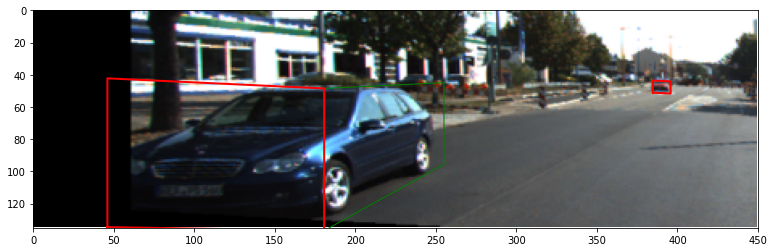

In [6]:
class ImagePreprocessor(KITTIData):
    def __init__(self, training=False, fliplr=False, shear_x=False, shear_y=False,
                 scale=False, crop=False, offset=False):
        super().__init__()
        
        self.training = training
        self.augFlags = {
            "fliplr":fliplr,
            "shear_x":shear_x,
            "shear_y":shear_y,
            "scale":scale,
            "crop":crop,
            "offset":offset
            }
        self.augParams = {
            "fliplr":False,
            "shear_x":0,
            "shear_y":0,
            "scale_x":1,
            "scale_y":1,
            "offset":[0,0]
            }
        self.outSize = np.array([450,135]) # x,y
        self.suppression_captureRate = .15
    
    def setAugParams(self, img):
        self.inSize = np.array(img.size) # x,y
        
        if self.training:
            if self.augFlags["fliplr"]:
                self.augParams["fliplr"] = rand()>.5
            if self.augFlags["shear_x"]:
                self.augParams["shear_x"] = (rand()-.5)*2*self.augFlags["shear_x"]
            if self.augFlags["shear_y"]:
                self.augParams["shear_y"] = (rand()-.5)*2*self.augFlags["shear_y"]
            if self.augFlags["scale"]:
                self.augParams["crop_x"] = randint((2*self.augFlags["scale"]-1)*self.inSize[0],self.inSize[0])
                self.augParams["crop_y"] = randint((2*self.augFlags["scale"]-1)*self.inSize[1],self.inSize[1])
                self.augParams["offset_x"] = randint(0,self.inSize[0]-self.augParams["crop_x"])
                self.augParams["offset_y"] = randint(0,self.inSize[1]-self.augParams["crop_y"])
    
    def preprocessImage(self, PILimg):
        img = PILimg
        self.setAugParams(img)
        
        if self.training:
            if self.augFlags["fliplr"] and self.augParams["fliplr"]:
                img = ImageOps.mirror(img)
            affined = tf.affine(img, angle=0,
                                    translate=(0,0),
                                    scale=self.augFlags["scale"],
                                    shear=[self.augParams["shear_x"],self.augParams["shear_y"]]
                                   )
            cropped = tf.crop(affined, self.augParams["offset_y"], self.augParams["offset_x"],
                              self.augParams["crop_y"], self.augParams["crop_x"])
        else:
            cropped = img
        resized = transforms.Resize(self.outSize[::-1])(cropped)
        resized = transforms.ToTensor()(resized)
        
        return resized
    
    def captured_rate(self, bb_ccwh, img_size):
        # determine the (x, y)-coordinates of the intersection rectangle
        c_x, c_y, w, h = bb_ccwh
        img_w, img_h = img_size[0], img_size[1]
        
        area_bb = w*h
        # intersection area
        x0 = max(0, c_x-w/2)
        x1 = min(img_w, c_x+w/2)
        y0 = max(0, c_y-h/2)
        y1 = min(img_h, c_y+h/2)
        area_intersection = (x1-x0)*(y1-y0)
        
        if x1<x0 or y1<y0:
            area_intersection = 0
        
        return area_intersection/(area_bb+.00001)
    
    def preprocessAnno(self, pts2D_fr, pts2D_lr):
        array = np.append(pts2D_fr, pts2D_lr).reshape([8,2])
        # fliplr, scale, shear_x, shear_y, offset, crop
        if self.training:
            if self.augFlags["fliplr"] and self.augParams["fliplr"]:
                array[:,0] = self.inSize[0] - array[:,0]
                array[0:2,:],array[2:4,:],array[4:6,:],array[6:8,:] =\
                     array[2:4,:].copy(),array[0:2,:].copy(),array[6:8,:].copy(),array[4:6,:].copy()
            if self.augFlags["scale"]:
                array = array*self.augFlags["scale"] + self.inSize*(1-self.augFlags["scale"])/2
            if self.augFlags["shear_x"]:
                off_y = np.array(array[:,1]-self.inSize[1]/2)
                array[:,0] -= off_y*np.tan(self.augParams["shear_x"]/180*np.pi)
            if self.augFlags["shear_y"]:
                off_x = np.array(array[:,0]-self.inSize[0]/2)
                array[:,1] -= off_x*np.tan(self.augParams["shear_y"]/180*np.pi)
            if self.augFlags["scale"]:
                array -= np.array([self.augParams["offset_x"], self.augParams["offset_y"]])
                array *= self.outSize/np.array([self.augParams["crop_x"], self.augParams["crop_y"]])
        else:
            array *= self.outSize/self.inSize
        pts2D_fr = array[:4,:]
        pts2D_lr = array[4:,:]
        return pts2D_fr, pts2D_lr
    
    def anno2objsList(self, img_name):
        # return list which contains objects
        annotations = self.getAnnotation(img_name)
        _, _, P2, _, _, _, _ = self.readCalib(img_name)
        objects = []
        for _, anno in annotations.iterrows():
            #if anno["type"] == "DontCare":
            if not anno["type"] in ['Car', 'Van', 'Truck']:
                continue
            pts2D_fr, pts2D_lr, cos_fr, cos_lr = self.calcPseudo3Dbb(anno, P2)
            pts2D_fr_aug, pts2D_lr_aug = self.preprocessAnno(pts2D_fr, pts2D_lr)
            
            # 元画像に写っている面積が小さければ出力しない
            # 変換後の画像に写っている面積が小さければ出力しない
            bb2D_aug = self.arrays2bb(pts2D_fr_aug, pts2D_lr_aug)
            bb2D = self.arrays2bb(pts2D_fr, pts2D_lr)
            if self.captured_rate(bb2D, self.inSize)<self.suppression_captureRate:
                continue
            elif self.captured_rate(bb2D_aug, self.outSize)<self.suppression_captureRate:
                continue
            obj = self.array2Pseudo3Dbb(pts2D_fr_aug, pts2D_lr_aug, cos_fr, cos_lr)
            objects.append(obj)
        return objects
    
    def anno2listsObj(self, img_name):
        # return dictionary which contains lists of object informatation
        annotations = self.getAnnotation(img_name)
        _, _, P2, _, _, _, _ = self.readCalib(img_name)
        listObject = {"coords":[], "poses":[]}
        for _, anno in annotations.iterrows():
            #if anno["type"] == "DontCare":
            if not anno["type"] in ['Car', 'Van', 'Truck']:
                continue
            pts2D_fr, pts2D_lr, cos_fr, cos_lr = self.calcPseudo3Dbb(anno, P2)
            pts2D_fr_aug, pts2D_lr_aug = self.preprocessAnno(pts2D_fr, pts2D_lr)
            
            # 元画像に写っている面積が小さければ出力しない
            # 変換後の画像に写っている面積が小さければ出力しない
            bb2D_aug = self.arrays2bb(pts2D_fr_aug, pts2D_lr_aug)
            bb2D = self.arrays2bb(pts2D_fr, pts2D_lr)
            if self.captured_rate(bb2D, self.inSize)<self.suppression_captureRate:
                continue
            elif self.captured_rate(bb2D_aug, self.outSize)<self.suppression_captureRate:
                continue
            
            listObject["coords"].append(np.append(pts2D_fr_aug, pts2D_lr_aug).reshape([8,2]))
            listObject["poses"].append(np.append(cos_fr, cos_lr))
        return listObject
    
    def plotPseudo3Dbb(self, img_name):
        img = self.getPILImg(img_name)
        img = self.preprocessImage(img)
        img = np.rollaxis(np.array(img),0,3)
        
        plt.figure(figsize=(15, 4))
        plt.imshow(img)
        
        objs = self.anno2objsList(img_name)
        for obj in objs:
            if not np.isnan(obj["pose"][1]):
                plt.plot(obj["coord"][[4,5,7,6,4],0],obj["coord"][[4,5,7,6,4],1], "g", linewidth=1)
            if not np.isnan(obj["pose"][0]):
                plt.plot(obj["coord"][[0,1,3,2,0],0],obj["coord"][[0,1,3,2,0],1], "r", linewidth=2)
        
        plt.xlim([0,img.shape[1]])
        plt.ylim([img.shape[0],0])

    def __getitem__(self, idx):
        # Get data for pytorch
        # preprocess is done in self.getitem, and return except for gt
        # because batch process cannot treat not-fixed length
        img_name = self.img_names[idx]
        img = self.getPILImg(img_name)
        img = self.preprocessImage(img)
        
        # regularization of coordination
        targets = self.anno2listsObj(img_name)
        if len(targets["coords"])>0:
            targets["coords"] = torch.as_tensor(targets["coords"])
            targets["coords"] /= self.outSize
            targets["coords"] = targets["coords"].reshape([-1,16])
        else:
            targets["coords"] = torch.zeros([0,16], dtype=torch.float64)
        targets["poses"] = torch.as_tensor(targets["poses"]).float()
        # todo : label設定する
        targets["labels"] = torch.zeros(targets["coords"].shape[-2]).long() # .shape[-1]はcoord数の16、.shape[-2]はlabel数
            
        # set bounding box for matching
        coords = targets["coords"].detach().numpy()
        bbox_normed = torch.as_tensor([self.arrays2bb(coord) for coord in coords], dtype=torch.float64).reshape([-1,4])
        targets["boxes"] = bbox_normed*torch.as_tensor(np.append(self.outSize,self.outSize)) # アスペクト比を調整
        
        return img, targets

vehicleAug = ImagePreprocessor(training=True, fliplr=True, shear_x=False, shear_y=10,
                 scale=0.7, crop=False, offset=False)
i = 1
vehicleAug.plotPseudo3Dbb(KITTIDataset.img_names[i])

{'boxes': tensor([[193.0868, 171.1594, 386.1736, 197.6812],
         [ 78.8976, 181.0827, 157.7952, 177.8346]], dtype=torch.float64),
 'coords': tensor([[0.6565, 1.2399, 0.6565, 0.6336, 0.8582, 1.1701, 0.8582, 0.5357, 0.5450,
          0.9873, 0.5450, 0.6389, 0.6565, 1.2399, 0.6565, 0.6336],
         [0.3343, 0.7428, 0.3343, 0.6911, 0.3507, 0.7345, 0.3507, 0.6827, 0.3340,
          0.7394, 0.3340, 0.6905, 0.3343, 0.7428, 0.3343, 0.6911]],
        dtype=torch.float64),
 'labels': tensor([0, 0]),
 'poses': tensor([[0.8822, 0.2700],
         [0.9996, 0.0085]])}

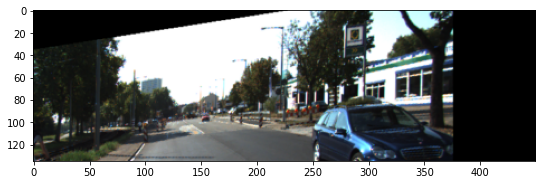

In [7]:
img, targets = vehicleAug[1]

plt.figure(figsize=(9,3))
plt.imshow(np.rollaxis(np.array(img),0,3))
targets

In [8]:
len(vehicleAug)

7481

# Creating Dataset

In [9]:
img_list = vehicleAug.img_names
train_list, val_list = train_test_split(img_list, test_size=0.05, shuffle=True, random_state=0)
print("train dataset has ", len(train_list), "images.")
print("val dataset has ", len(val_list), "images.")

train dataset has  7106 images.
val dataset has  375 images.


In [10]:
class VehicleDataset(Dataset):
    def __init__(self, dataList, training=True):
        self.dataset = ImagePreprocessor(training=training, fliplr=True, shear_x=False, shear_y=10,
                                         scale=0.7, crop=False, offset=False)
        self.dataset.img_names = dataList
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

In [11]:
train_dataset = VehicleDataset(train_list, training=True)
val_dataset = VehicleDataset(val_list, training=False)
val_dataset_noaug = VehicleDataset(val_list, training=False)

In [12]:
BATCH_SIZE = 16
num_worker = 4

def collate_fn(batch):
    return tuple(zip(*batch))

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn, num_workers=num_worker)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=collate_fn, num_workers=num_worker)
val_loader_noaug = DataLoader(dataset=val_dataset_noaug, batch_size=BATCH_SIZE, shuffle=False,
                              collate_fn=collate_fn, num_workers=num_worker)

# Model

In [13]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=num_classes)
        self.model.pose_embed = nn.Linear(in_features=self.in_features,out_features=2)
        self.model.coord_embed = nn.Linear(in_features=self.in_features,out_features=16)
        self.model.num_classes = num_classes
        self.model.num_queries = num_queries
        
        
        hidden_dim = self.model.transformer.d_model
        self.model.query_embed = nn.Embedding(num_queries, hidden_dim)
        
    def forward(self,images):
        ## from facebook/DETR
        if isinstance(images, (list, torch.Tensor)):
            images = nested_tensor_from_tensor_list(images)
        features, pos = self.model.backbone(images)

        src, mask = features[-1].decompose()
        assert mask is not None
        hs = self.model.transformer(self.model.input_proj(src), mask, self.model.query_embed.weight, pos[-1])[0]

        outputs_class = self.model.class_embed(hs)
        outputs_pose = self.model.pose_embed(hs)
        outputs_coord = self.model.coord_embed(hs)
        out = {'pred_logits': outputs_class[-1],
               'pred_poses': outputs_pose[-1],
               'pred_coords': outputs_coord[-1]}
        return out

# Matcher and Bipartite Matching Loss

In [14]:
matcher = HungarianMatcher()

weight_dict = {'loss_ce': 1, 'loss_poses': 1 , 'loss_coords': 1}

losses = ['labels', 'poses', 'coords']

# Evaluation Function

In [15]:
class SetVehicleCriterion(SetCriterion):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.poseThresh = .5
    
    @staticmethod
    def array2bb(coord, pose, poseThresh):
        # convert from array to 2Dbb
        array2D = coord.reshape([-1, 8, 2]) # shape:[batch, leftBottom~rightTop x2, (x,y)]
        pose = pose.reshape([-1, 2])
        bbox = np.zeros((array2D.shape[0],4))
        cannotSeeFrontOrRear = np.logical_and(pose[:,0]<poseThresh, poseThresh<pose[:,1])
        cannotSeeSide = np.logical_and(poseThresh<pose[:,0], pose[:,1]<poseThresh)

        tmp1 = array2D[cannotSeeFrontOrRear,0:4,:]
        tmp2 = array2D[cannotSeeSide,4:8,:]

        array2D[cannotSeeFrontOrRear,0:4,:] = np.inf
        array2D[cannotSeeSide,4:8,:] = np.inf
        x0 = np.min(array2D[:,:,0], axis=1)
        y0 = np.min(array2D[:,:,1], axis=1)
        array2D[cannotSeeFrontOrRear,0:4,:] = -np.inf
        array2D[cannotSeeSide,4:8,:] = -np.inf
        x1 = np.max(array2D[:,:,0], axis=1)
        y1 = np.max(array2D[:,:,1], axis=1)
        array2D[cannotSeeFrontOrRear,0:4,:] = tmp1
        array2D[cannotSeeSide,4:8,:] = tmp2
    
        bbox[:,0] = (x0+x1)/2 #cx
        bbox[:,1] = (y0+y1)/2 #cy
        bbox[:,2] = x1-x0 #w
        bbox[:,3] = y1-y0 #h
        
        bbox[:,0] *= 450 # 画像上の座標に変換
        bbox[:,1] *= 135
        bbox[:,2] *= 450
        bbox[:,3] *= 135
    
        return bbox
    
    def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes[idx] = target_classes_o
            
        
        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}

        return losses
    
    def loss_poses(self, outputs, targets, indices, num_boxes):
        assert 'pred_poses' in outputs
        losses = {}

        idx = self._get_src_permutation_idx(indices)
        src_poses = outputs['pred_poses'].sigmoid()[idx]
        with torch.no_grad():
            target_poses = torch.cat([t['poses'][i] for t, (_, i) in zip(targets, indices)], dim=0).reshape([-1,2])
            target_poses_bin = torch.logical_not(torch.isnan(target_poses)).float()
            lr = target_poses
            lr[torch.isnan(lr)] = 1 # use cos(angle) as training rate

        loss_poses = F.binary_cross_entropy(src_poses, target_poses_bin, reduction='none')
        losses['loss_poses'] = (loss_poses*lr).sum() / num_boxes
        
        return losses
    
    def loss_coords(self, outputs, targets, indices, num_boxes):
        assert 'pred_coords' in outputs
        losses = {}
        
        idx = self._get_src_permutation_idx(indices)
        src_coords = outputs['pred_coords'][idx]
        target_poses = torch.cat([t['poses'][i] for t, (_, i) in zip(targets, indices)], dim=0)
        target_coords = torch.cat([t['coords'][i] for t, (_, i) in zip(targets, indices)], dim=0)
    
        loss_coords = F.l1_loss(src_coords, target_coords, reduction='none')
        
        loss_weight = torch.as_tensor([450, 135]*8)
        loss_coords = loss_coords*loss_weight
        loss_coords = torch.clamp(loss_coords,0,50) # 誤差が大きすぎるものはcliping
        loss_coords /= 450
        
        # もし車両の面が見えていなければ学習させない
        with torch.no_grad():
             # coordと同じshapeで重みが設定されたtensorを作成
            cos_weight = torch.stack([target_poses.reshape(-1) for _ in range(8)]).T.reshape([-1,16]).float()
             # 面が見えていない場合はcoordを学習させないためのmask
            loss_mask = torch.logical_not(torch.isnan(cos_weight)).bool()
        loss_coords = loss_coords[loss_mask]*cos_weight[loss_mask]
    
        losses['loss_coords'] = loss_coords.sum() / num_boxes
        
        return losses

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'poses': self.loss_poses,
            'coords': self.loss_coords
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)
    
    def forward(self, outputs, targets):
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}
        coords = outputs["pred_coords"].detach().numpy()
        poses = outputs["pred_poses"].detach().numpy()

        outputs_without_aux["pred_boxes"] =\
            torch.as_tensor([self.array2bb(coord, pose, self.poseThresh) for coord, pose in zip(coords,poses)])
        
        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs_without_aux, targets)

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        if is_dist_avail_and_initialized():
            torch.distributed.all_reduce(num_boxes)
        num_boxes = torch.clamp(num_boxes / get_world_size(), min=1).item()

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        return losses

# Engine

In [16]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [17]:
n_folds = 5
seed = 42
num_classes = 2
num_queries = 30
null_class_coef = 0.5
LR = 2e-5
EPOCHS = 200

In [18]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model = model.to(device)
criterion = SetVehicleCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)

Using cache found in /Users/takeshikibayashi/.cache/torch/hub/facebookresearch_detr_master


In [19]:
def setOptimizer(lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[100,200], gamma=0.1, last_epoch=-1)
    return optimizer, scheduler

optimizer, scheduler = setOptimizer(LR)

In [20]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch,history):
    
    model.train()
    criterion.train()
    
    total_loss = AverageMeter()
    labels_loss = AverageMeter()
    poses_loss = AverageMeter()
    coords_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        
        total_loss.update(losses.item(),BATCH_SIZE)
        labels_loss.update(loss_dict['loss_ce'].item())
        if loss_dict['loss_poses']:
            poses_loss.update(loss_dict['loss_poses'].item())
        if loss_dict['loss_coords']:
            coords_loss.update(loss_dict['loss_coords'].item())
        tk0.set_postfix(total_loss=total_loss.avg,
                        labels=labels_loss.avg*weight_dict['loss_ce'],
                        pose=poses_loss.avg*weight_dict['loss_poses'],
                        coords=coords_loss.avg*weight_dict['loss_coords'])
    
    if scheduler is not None:
        scheduler.step()
        
    history.loc[epoch, 'train_loss'] = total_loss.avg
    history.loc[epoch, 'train_loss_labels'] = labels_loss.avg*weight_dict['loss_ce']
    history.loc[epoch, 'train_loss_poses'] = poses_loss.avg*weight_dict['loss_poses']
    history.loc[epoch, 'train_loss_coords'] = coords_loss.avg*weight_dict['loss_coords']
        
    return total_loss

In [25]:
def eval_fn(data_loader, model,criterion, device, epoch, history):
    model.eval()
    criterion.eval()
    
    total_loss = AverageMeter()
    labels_loss = AverageMeter()
    poses_loss = AverageMeter()
    coords_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = data_loader
        #tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
            total_loss.update(losses.item(),BATCH_SIZE)
            labels_loss.update(loss_dict['loss_ce'].item())
            if loss_dict['loss_poses']:
                poses_loss.update(loss_dict['loss_poses'].item())
            if loss_dict['loss_coords']:
                coords_loss.update(loss_dict['loss_coords'].item())
                
            #tk0.set_postfix(loss=summary_loss.avg)
            
    history.loc[epoch, 'val_loss'] = total_loss.avg
    history.loc[epoch, 'val_loss_labels'] = labels_loss.avg*weight_dict['loss_ce']
    history.loc[epoch, 'val_loss_poses'] = poses_loss.avg*weight_dict['loss_poses']
    history.loc[epoch, 'val_loss_coords'] = coords_loss.avg*weight_dict['loss_coords']
    
    return total_loss

In [26]:
for param in model.model.backbone.parameters():
    param.required_grad = False
best_map = np.inf
history = pd.DataFrame()

for epoch in range(EPOCHS):
    train_loss = train_fn(train_loader, model,criterion, optimizer,device,scheduler=scheduler,epoch=epoch,history=history)
    eval_loss = eval_fn(val_loader, model,criterion, device, epoch, history)
    
    #valid_map_score = calculate_final_score(predictions,0.5,form='coco')

    print('|EPOCH {}| LEARNING RATE {:.0e}| TRAIN_LOSS {:.5f}| EVAL_LOSS {:.5f}|'.format(
        epoch+1,scheduler.get_lr()[0], train_loss.avg,eval_loss.avg))

    if eval_loss.avg < best_map:
        best_map = eval_loss.avg
        print('Best model found in Epoch {}........Saving Model'.format(epoch+1))
        torch.save(model.state_dict(), '../model/0127_epoch{}_evalLoss{:.5f}.pth'.format(epoch+1,eval_loss.avg))

Widget Javascript not detected.  It may not be installed or enabled properly.



|EPOCH 1| LEARNING RATE 2e-05| TRAIN_LOSS 2.28669| EVAL_LOSS 2.20693|
Best model found in Epoch 1........Saving Model
Widget Javascript not detected.  It may not be installed or enabled properly.



|EPOCH 2| LEARNING RATE 2e-05| TRAIN_LOSS 2.14574| EVAL_LOSS 2.20430|
Best model found in Epoch 2........Saving Model
Widget Javascript not detected.  It may not be installed or enabled properly.



|EPOCH 3| LEARNING RATE 2e-05| TRAIN_LOSS 1.97293| EVAL_LOSS 2.16325|
Best model found in Epoch 3........Saving Model
Widget Javascript not detected.  It may not be installed or enabled properly.



|EPOCH 4| LEARNING RATE 2e-05| TRAIN_LOSS 1.79544| EVAL_LOSS 2.13373|
Best model found in Epoch 4........Saving Model
Widget Javascript not detected.  It may not be installed or enabled properly.



|EPOCH 5| LEARNING RATE 2e-05| TRAIN_LOSS 1.83579| EVAL_LOSS 2.13743|
Widget Javascript not detected.  It may not be installed or enabled properly.



|EPOCH 6| LEARNING RATE 2e-05| TRAIN_LOSS 1.96338| EVAL_LOSS 2.10340|
Best model found in Epoch 6........Saving Model
Widget Javascript not detected.  It may not be installed or enabled properly.


KeyboardInterrupt: 

In [29]:
import pickle
with open("../output/0127_history.pkl", "wb") as a:
    pickle.dump(history , a)

(0.0, 200.0)

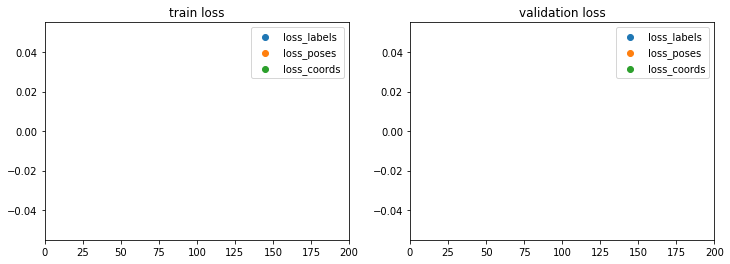

In [33]:
index = range(len(loss_labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("train loss")
plt.scatter(index[10:], history['train_loss_labels'][10:])
plt.scatter(index[10:], history['train_loss_poses'][10:])
plt.scatter(index[10:], history['train_loss_coords'][10:])
plt.legend(["loss_labels", "loss_poses", "loss_coords"])
plt.xlim([0,200])

plt.subplot(1,2,2)
plt.title("validation loss")
plt.scatter(index[10:], history['val_loss_labels'][10:])
plt.scatter(index[10:], history['val_loss_poses'][10:])
plt.scatter(index[10:], history['val_loss_coords'][10:])
plt.legend(["loss_labels", "loss_poses", "loss_coords"])
plt.xlim([0,200])

(0.0, 200.0)

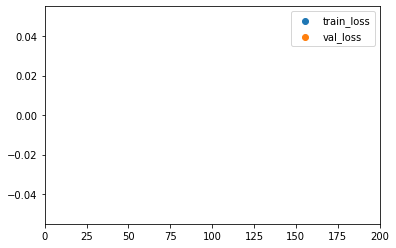

In [34]:
plt.scatter(index[10:], history['train_loss'][10:])
plt.scatter(index[10:], history['val_loss'][10:])
plt.legend(["train_loss", "val_loss"])
plt.xlim([0,200])

# Inference with validation data

In [152]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.eval()
state_dict = torch.load("../model/0120_epoch144_evalLoss0.25238.pth")
model.load_state_dict(state_dict)

Using cache found in /Users/takeshikibayashi/.cache/torch/hub/facebookresearch_detr_master


RuntimeError: Error(s) in loading state_dict for DETRModel:
	size mismatch for model.pose_embed.weight: copying a param with shape torch.Size([1, 256]) from checkpoint, the shape in current model is torch.Size([2, 256]).
	size mismatch for model.pose_embed.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for model.coord_embed.weight: copying a param with shape torch.Size([12, 256]) from checkpoint, the shape in current model is torch.Size([16, 256]).
	size mismatch for model.coord_embed.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([16]).

In [ ]:
def drawInference(PILImage, thresh=.5):
    logit_thresh = thresh
    img = PILImage
    #img = ImageOps.mirror(img)
    img = transforms.Resize([135,450], interpolation=Image.LANCZOS)(img)
    img = tf.to_tensor(img)

    output = model(img[None])
    output["pred_logits"] = output["pred_logits"].sigmoid()
    output = {k: v[0].detach().numpy() for k, v in output.items()}

    isVehicle = np.logical_and(output["pred_logits"][:,0]>output["pred_logits"][:,1],
                               output["pred_logits"][:,0]>logit_thresh)

    imgshow = np.rollaxis(np.array(img),0,3)
    plt.figure(figsize=(450/my_dpi, 135/my_dpi), dpi=my_dpi)
    plt.imshow(imgshow)
    for i, flag in enumerate(isVehicle):
        if flag:
            coord = np.reshape(output["pred_coords"][i],[6,2])*np.array([imgshow.shape[1],imgshow.shape[0]])
            x = coord[:,0]
            y = coord[:,1]
            if output["pred_poses"][i]>0:
                plt.plot(x[[2,0,1,3,5,4,2,3]],y[[2,0,1,3,5,4,2,3]])
            else:
                plt.plot(x[[0,1,5,4,0]],y[[0,1,5,4,0]])
            #if 0<x[0]<400 and 0<y[0]<130:
            #    plt.text(x[0],y[0]+5, r'query_'+str(i), size=15, color="red")
            #    for j in range(6):
            #        plt.text(x[j],y[j], str(j), size=15, color="green")
    plt.xlim([0,imgshow.shape[1]])
    plt.ylim([imgshow.shape[0],0])
    plt.axis("off")
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

for i in range(10):
    img = vehicleAug.getPILImg(val_list[i+20])
    drawInference(img, thresh=.7)

In [ ]:
from moviepy.editor import VideoClip, VideoFileClip
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython.display import HTML

In [ ]:
my_dpi = 72
fig, ax = plt.subplots(figsize=(5, 2))
#fig, ax = plt.subplots(figsize=(450/my_dpi, 135/my_dpi), dpi=my_dpi)
ax.axis("off")

def make_frame(img, thresh=.7):
    ax.clear()
    
    logit_thresh = thresh
    crop_t = 350
    crop_l = 300
    img = img[crop_t:int(crop_t+(1280-crop_l)/450*135),crop_l:,:]
    img = Image.fromarray(np.uint8(img))
    img = transforms.Resize([135,450], interpolation=Image.LANCZOS)(img)
    img = tf.to_tensor(img)

    output = model(img[None])
    output["pred_logits"] = output["pred_logits"].sigmoid()
    output = {k: v[0].detach().numpy() for k, v in output.items()}

    isVehicle = np.logical_and(output["pred_logits"][:,0]>output["pred_logits"][:,1],
                               output["pred_logits"][:,0]>logit_thresh)

    imgshow = np.rollaxis(np.array(img),0,3)
    ax.imshow(imgshow)
    for i, flag in enumerate(isVehicle):
        if flag:
            coord = np.reshape(output["pred_coords"][i],[6,2])*np.array([imgshow.shape[1],imgshow.shape[0]])
            x = coord[:,0]
            y = coord[:,1]
            if output["pred_poses"][i]>0:
                ax.plot(x[[2,0,1,3,5,4,2,3]],y[[2,0,1,3,5,4,2,3]])
            else:
                ax.plot(x[[0,1,5,4,0]],y[[0,1,5,4,0]])
            #if 0<x[0]<400 and 0<y[0]<130:
            #    ax.text(x[0],y[0]+5, r'query_'+str(i), size=15, color="red")
            #    for j in range(6):
            #        ax.text(x[j],y[j], str(j), size=15, color="green")
                
    ax.set_xlim([0,imgshow.shape[1]])
    ax.set_ylim([imgshow.shape[0],0])
    ax.axis("off")
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    
    return mplfig_to_npimage(fig)

In [193]:
output = '../output/output_video.mp4'
clip1 = VideoFileClip("../output/project_video.mp4")#.subclip(40,41)
clip = clip1.fl_image(make_frame)
clip.write_videofile(output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]Moviepy - Building video ../output/output_video.mp4.
Moviepy - Writing video ../output/output_video.mp4


t:   1%|          | 9/1260 [00:05<13:43,  1.52it/s, now=None]

ValueError: cannot reshape array of size 16 into shape (6,2)

In [ ]:
HTML("""
<video width="450" height="135" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
%%HTML
<video width="450" height="135" controls>
  <source src=output type="video/mp4">
</video>

# test for albumentation

In [43]:
import albumentations as A

In [44]:
transform = A.Compose(
    [A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1)],
)

In [46]:
print(type(img))

<class 'PIL.PngImagePlugin.PngImageFile'>


In [63]:
img = np.array(img)
transformed = transform(image=img)

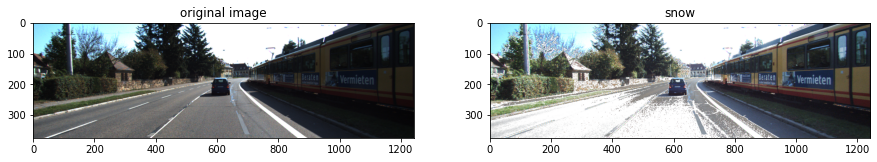

In [64]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("snow")
plt.imshow(transformed['image'])